# XGBoost Model for Energy Demand in Spain

## XGBoost

XGBoost (eXtreme Gradient Boosting) is a powerful, scalable machine learning algorithm based on gradient boosting. It builds decision trees sequentially, where each tree corrects the errors of the previous one, optimizing for a custom loss function.

XGBoost can be effectively applied to time series analysis, including energy demand forecasting, by treating the problem as a supervised learning task. Instead of directly modeling the temporal dependencies, XGBoost can leverage lagged features, rolling statistics (e.g., moving averages), and other relevant external factors (e.g. weather or public holidays) as input features. Its flexibility and ability to handle nonlinear relationships make it well-suited for energy demand forecasting.

## Multi-Output XGBoost

The model needs to be able to make 24 hourly predictions for the following day at noon. This can be achieved using:
- **One model per hour** : 24 different models, one for each hour
    - Pros : Specializes in hour-specific patterns, improving accuracy.
    - Cons : Computationally expensive and lacks inter-hour dependency learning.
- **Recursive Autoregressive Approach** : predict one hour at a time, feeding predictions back as inputs for future hours
    - Pros : Captures sequential dependencies dynamically with a single model.
    - Cons : Errors compound over time, potentially degrading later predictions.

Therefore, a one model per hour model will be used. The compounding errors of the recursive autoregressive approach will become too large since 36 time steps need to be predicted. However, not being able to capture inter-hour dependencies is a big drawback of this method, which could be overcome by using a more complex neural-network style model.

## Data Exploration

This section explores the weather data for five major cities in Spain: Madrid, Barcelona, Seville, Valencia and Bilbao. These cities were chosen due to having large populations and distributed well around Spain, thus providing a good coverage of the country.

The energy demand dataset has already been explored in [SARIMA_demand.ipynb](SARIMA_demand.ipynb).

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from scipy.spatial import Voronoi, voronoi_plot_2d
import geopandas as gpd
import matplotlib.patches as mpatches
import shapely.geometry
from sklearn.multioutput import MultiOutputRegressor
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.decomposition import PCA

Find duplicate and missing values:

In [85]:
from datetime import timedelta

cities = ['barcelona', 'seville', 'valencia', 'bilbao']

df = pd.read_csv('data/weather_data_madrid.csv')

for city in cities:
    df_temp = pd.read_csv(f'data/weather_data_{city}.csv')
    df = pd.concat([df, df_temp])

df['datetime'] = pd.to_datetime(df['datetime'], errors='coerce')

error_count = 0
prev_datetime = df['datetime'].iloc[0]

for i in range(1, len(df)):
    current_datetime = df['datetime'].iloc[i]

    if prev_datetime + timedelta(hours=1) != current_datetime:
        if prev_datetime == current_datetime:
            print(f'Duplicate data around: {prev_datetime} - {df["name"].iloc[i]}')
        else:
            print(f'Missing data around: {prev_datetime} - {df["name"].iloc[i]}')
        error_count += 1

    prev_datetime = current_datetime


Missing data around: 2020-03-29 01:00:00 - Madrid, Comunidad de Madrid, España
Duplicate data around: 2020-10-25 02:00:00 - Madrid, Comunidad de Madrid, España
Missing data around: 2021-03-28 01:00:00 - Madrid, Comunidad de Madrid, España
Duplicate data around: 2021-10-31 02:00:00 - Madrid, Comunidad de Madrid, España
Missing data around: 2022-03-27 01:00:00 - Madrid, Comunidad de Madrid, España
Duplicate data around: 2022-10-30 02:00:00 - Madrid, Comunidad de Madrid, España
Missing data around: 2023-03-26 01:00:00 - Madrid, Comunidad de Madrid, España
Duplicate data around: 2023-10-29 02:00:00 - Madrid, Comunidad de Madrid, España
Missing data around: 2024-03-31 01:00:00 - Madrid, Comunidad de Madrid, España
Duplicate data around: 2024-10-27 02:00:00 - Madrid, Comunidad de Madrid, España
Missing data around: 2024-11-01 00:00:00 - Barcelona, Catalunya, Espanya
Missing data around: 2020-03-29 01:00:00 - Barcelona, Catalunya, Espanya
Duplicate data around: 2020-10-25 02:00:00 - Barcelona

Due to daylight savings, there is missing or duplicated data within the dataset. To handle this missing data will be copied from the previous hour whilst duplicated data will have one of the rows deleted.

In [97]:
# Remove duplicate rows
df_2 = df.reset_index().drop_duplicates(subset=['datetime', 'name'], 
                                                        keep='first')

# Add missing rows by copying the previous row's data
prev_datetime = df_2['datetime'].iloc[0]

new_rows = []
for i in range(1, len(df_2)):
    current_datetime = df_2['datetime'].iloc[i]

    if df_2['name'].iloc[i] == df_2['name'].iloc[i - 1]:

        while prev_datetime + timedelta(hours=1) < current_datetime:
            new_row = df_2.iloc[i - 1].copy()
            new_row['datetime'] = prev_datetime + timedelta(hours=1)
            new_rows.append(new_row)
            prev_datetime += timedelta(hours=1)
    
    prev_datetime = current_datetime


if new_rows:
    df_2 = pd.concat([df_2, pd.DataFrame(new_rows)], ignore_index=True)


df_2 = df_2.sort_values(by=['name', 'datetime']).reset_index(drop=True)

# Check for missing or duplicate rows
prev_datetime = df_2['datetime'].iloc[0]
error_count = 0
for i in range(1, len(df_2)):
    current_datetime = df_2['datetime'].iloc[i]

    if prev_datetime + timedelta(hours=1) != current_datetime:
        if prev_datetime == current_datetime:
            print(f'Duplicate data around: {prev_datetime} - {df_2["name"].iloc[i]}')
            error_count += 1
        elif df_2['name'].iloc[i] != df_2['name'].iloc[i - 1]:
            pass
        else:
            print(f'Missing data around: {prev_datetime} - {df_2["name"].iloc[i]}')
            error_count += 1

    prev_datetime = current_datetime

print(f'{error_count} dulicate or missing data points')

0 dulicate or missing data points


In [ ]:
df_2.describe()

,index,datetime,temp,feelslike,dew,humidity,precip,precipprob,snow,snowdepth,windgust,windspeed,winddir,sealevelpressure,cloudcover,visibility,solarradiation,solarenergy,uvindex,severerisk
count,219245.000000,219245,219245.000000,219245.000000,219245.000000,219245.000000,219245.000000,219245.000000,219095.000000,219245.000000,219239.000000,219245.000000,219245.000000,219245.000000,219245.000000,219237.000000,219245.000000,219245.000000,219245.000000,0.0
mean,21923.413692,2022-05-02 12:00:00.000000512,17.346209,17.143355,10.177796,67.127486,0.074372,8.004744,0.000290,0.039449,19.813832,10.211290,187.915305,1017.411272,42.198768,13.086967,174.121210,0.626460,1.727501,NaN
min,0.000000,2019-11-01 00:00:00,-9.200000,-9.200000,-15.000000,2.380000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,983.000000,0.000000,0.000000,0.000000,0.000000,0.000000,NaN
25%,10962.000000,2021-01-30 18:00:00,11.900000,11.900000,6.000000,52.410000,0.000000,0.000000,0.000000,0.000000,11.500000,5.300000,87.000000,1013.300000,10.100000,10.000000,0.000000,0.000000,0.000000,NaN
50%,21923.000000,2022-05-02 12:00:00,16.900000,16.900000,10.100000,69.770000,0.000000,0.000000,0.000000,0.000000,16.900000,8.600000,210.000000,1017.000000,32.100000,11.300000,12.000000,0.000000,0.000000,NaN
75%,32885.000000,2023-08-02 06:00:00,22.600000,22.600000,14.600000,84.570000,0.000000,0.000000,0.000000,0.000000,25.600000,13.700000,282.000000,1021.500000,76.800000,16.200000,297.000000,1.100000,3.000000,NaN
max,43848.000000,2024-11-01 00:00:00,44.900000,45.900000,26.300000,100.000000,82.022000,100.000000,17.210000,49.000000,288.000000,127.500000,360.000000,1041.300000,100.000000,44.900000,1192.000000,4.300000,10.000000,NaN
std,12658.064719,NaN,7.450185,7.779413,6.023522,20.875288,0.863615,27.136724,0.039179,0.770211,12.350718,6.965122,108.929477,6.829353,34.111667,4.643124,256.579169,0.924248,2.580983,NaN


In [103]:
# Remove non-numerical or empty columns
df_3 = df_2.drop(['preciptype', 'severerisk', 'conditions', 'icon', 'stations'], axis=1)

print('There are {} missing values or NaNs in the weather data.'
    .format(df_3.isnull().values.sum()))

There are 164 missing values or NaNs in the weather data.


The data seems reasonable with minimums, maximums and means within the expected range.

All missing values will be filled with the previous values. There aren't many missing values and only snow, windgust and visibility are missing values.

In [104]:
df_3 = df_3.ffill()
print('There are {} missing values or NaNs in the weather data.'
    .format(df_3.isnull().values.sum()))

There are 0 missing values or NaNs in the weather data.


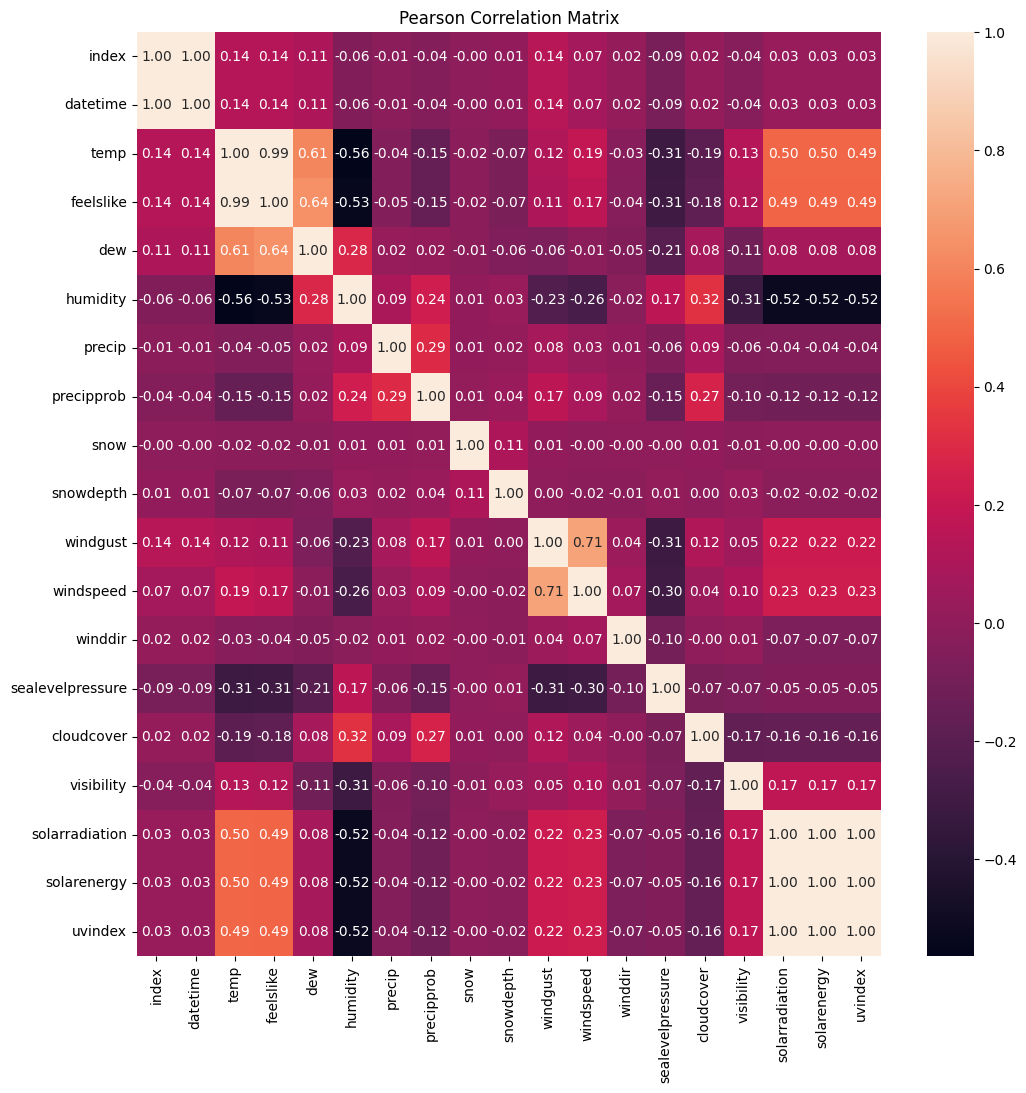

In [106]:
correlations = df_3.drop(columns=['name']).corr(method='pearson')
fig = plt.figure(figsize=(12, 12))
sns.heatmap(correlations, annot=True, fmt='.2f')
plt.title('Pearson Correlation Matrix')
plt.show()

Based on correlation matrix:
 - Can drop solar energy and uv index and just keep solar radiation as they're perfectly correlated
 - Can drop feels like as almost perfectly correlated with temp, or can create a feel vs actual difference feature

In [107]:
df_4 = df_3.drop(columns=['solarenergy', 'uvindex'])

## Creating Singular Dataframe

In [141]:
# Energy Load Data
df_final = pd.read_csv('data/actualTotalLoad.csv')
df_final['datetime'] = pd.to_datetime(df_final['datetime'], errors='coerce')
df_final.set_index('datetime', inplace=True)

# Weather Data
dfs = {name: group.reset_index(drop=True).set_index('datetime') for name, group in df_4.groupby('name')}

for df in dfs.values():
    city = df['name'].unique()
    city_str = str(city).split(',')[0].strip().lower().replace('è', 'e').replace("['", '')
    df = df.add_suffix('_{}'.format(city_str))
    df_final = df_final.merge(df, on=['datetime'], how='outer')
    df_final = df_final.drop([f'name_{city_str}', f'index_{city_str}'], axis=1)
    
df_final.columns

Index(['Actual Total Load (MW)', 'temp_barcelona', 'feelslike_barcelona',
       'dew_barcelona', 'humidity_barcelona', 'precip_barcelona',
       'precipprob_barcelona', 'snow_barcelona', 'snowdepth_barcelona',
       'windgust_barcelona', 'windspeed_barcelona', 'winddir_barcelona',
       'sealevelpressure_barcelona', 'cloudcover_barcelona',
       'visibility_barcelona', 'solarradiation_barcelona', 'temp_bilbao',
       'feelslike_bilbao', 'dew_bilbao', 'humidity_bilbao', 'precip_bilbao',
       'precipprob_bilbao', 'snow_bilbao', 'snowdepth_bilbao',
       'windgust_bilbao', 'windspeed_bilbao', 'winddir_bilbao',
       'sealevelpressure_bilbao', 'cloudcover_bilbao', 'visibility_bilbao',
       'solarradiation_bilbao', 'temp_madrid', 'feelslike_madrid',
       'dew_madrid', 'humidity_madrid', 'precip_madrid', 'precipprob_madrid',
       'snow_madrid', 'snowdepth_madrid', 'windgust_madrid',
       'windspeed_madrid', 'winddir_madrid', 'sealevelpressure_madrid',
       'cloudcover_mad

## Feature Engineering

To ensure robust model training, we follow the general rule of having at least 10 times more data points than features. Since a multi-output regression model has been chosen, each data point now represents a full day instead of a single hour. This reduces the number of data points by a factor of 24 while simultaneously increasing the number of features by a factor of 24.

The training dataset consists of 1,461 days. To maintain a 10:1 ratio of data points to features, we can use a maximum of 146 features.

With weather data for five cities, using the temperature for the last 24 hours from each city already accounts for 120 features. This leaves insufficient room for other critical features, such as previous demand values, time-based features (e.g., month, day of the week), or additional weather parameters.

To address this, a weighted average of the weather data from the five cities will be used instead of individual city data. The weights will be based on the population living closest to each city. A Voronoi diagram will be created with nodes at the cities to determine the populations within each city’s region.

This approach will include populations in Ceuta, Melilla, and the Balearic Islands, as they are connected to the Spanish electricity grid via submarine cables. However, it will exclude the Canary Islands, as their electrical grid operates independently.

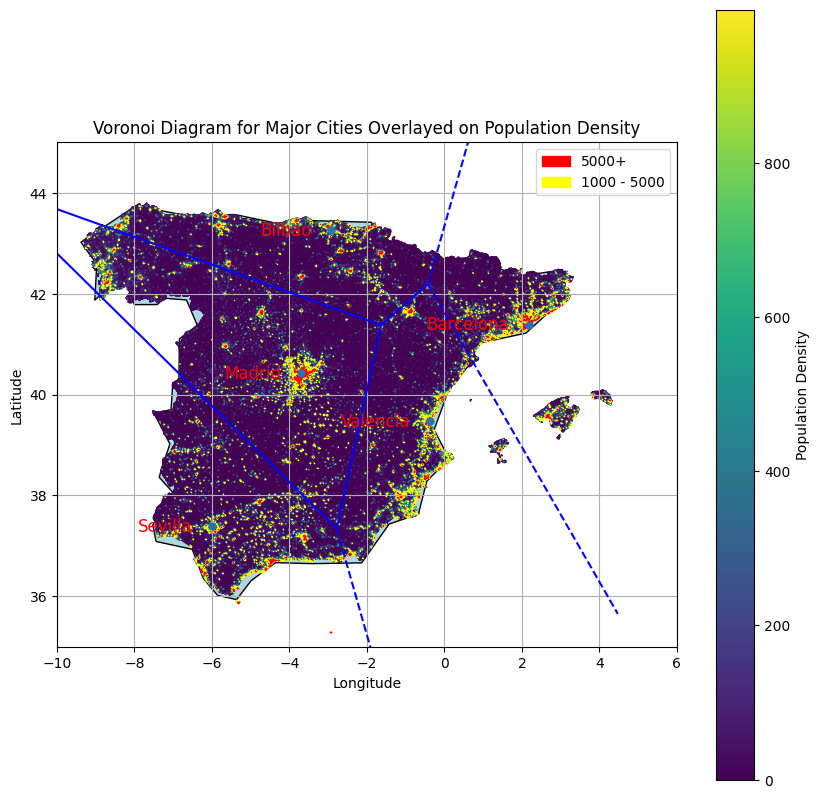

In [213]:
# Load the CSV file of population density data
df = pd.read_csv('data/population_density.csv')
df = df[(df['Y'] > 34)]

df_mid = df[(df['Z'] < 1000)]
df_large = df[(df['Z'] >= 1000) & (df['Z'] < 5000)]
df_xlarge = df[(df['Z'] >= 5000)]

df_mid = df_mid.sort_values(by='Z', ascending=True)

# Read the shapefile for world countries
shapefile_path = 'data/country_shapes/ne_110m_admin_0_countries.shp'
world = gpd.read_file(shapefile_path)

# Filter for Spain
spain = world[world['NAME'] == 'Spain']

# Define the coordinates of the 5 major cities
major_cities = {
    'Madrid': (-3.7033, 40.4169),
    'Barcelona': (2.1769, 41.3828),
    'Valencia': (-0.3764, 39.4700),
    'Sevilla': (-5.9900, 37.3900),
    'Bilbao': (-2.9236, 43.2569)
}
city_coords = np.array(list(major_cities.values()))

vor = Voronoi(city_coords)


fig, ax = plt.subplots(figsize=(10, 10))

spain.plot(ax=ax, color='lightblue', edgecolor='black')

# Add scatter plot with population density values as z-axis
scatter = ax.scatter(df_mid['X'], df_mid['Y'], c=df_mid['Z'], cmap='viridis', s=1, edgecolor='k' , linewidth=0)
scatter2 = ax.scatter(df_large['X'], df_large['Y'], c='yellow', s=1, edgecolor='k' , linewidth=0)
scatter3 = ax.scatter(df_xlarge['X'], df_xlarge['Y'], c='red', s=1, edgecolor='k' , linewidth=0)

# Add a colorbar
plt.colorbar(scatter, ax=ax, label='Population Density')

# Create custom legend labels for yellow and red
yellow_patch = mpatches.Patch(color='yellow', label='1000 - 5000')
red_patch = mpatches.Patch(color='red', label='5000+')
plt.legend(handles=[red_patch, yellow_patch], loc='upper right')

voronoi_plot_2d(vor, ax=ax, show_vertices=False, line_colors='blue', line_width=1.5, point_size=10)

# Annotate the cities
for city, coord in major_cities.items():
    ax.text(coord[0] - 0.5, coord[1] - 0.1, city, fontsize=12, ha='right', color='red')

ax.set_xlim(-10, 6)  # Spain's longitude range
ax.set_ylim(35, 45)  # Spain's latitude range

# Show the plot
plt.title("Voronoi Diagram for Major Cities Overlayed on Population Density")
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.grid(True)
plt.show()

The graph above shows how spain will be split, overlayed on the population density. Since each of the data points covers a 1km x 1km square, can use the population densities to calculate the populations within each region. These can then be normalised to sum to 1.

In [214]:
# Create a rectangle surrounding spain then a large rectangle surrounding it
polygon = shapely.wkt.loads('Polygon ((-10 35, -10 45, 6 45, 6 35, -10 35)))')
bound = polygon.buffer(20).envelope.boundary 

# Create many points along the rectangle boundary so Voroni regions don't go to infinity
boundarypoints = [bound.interpolate(distance=d) for d in range(0, np.ceil(bound.length).astype(int), 4)]
boundarycoords = np.array([[p.x, p.y] for p in boundarypoints])

#Create an array of all points on the boundary and inside the polygon
all_coords = np.concatenate((boundarycoords, city_coords)) 

vor = Voronoi(all_coords)

lines = [shapely.geometry.LineString(vor.vertices[line]) for line in 
    vor.ridge_vertices if -1 not in line]

polys = shapely.ops.polygonize(lines)
voronois = gpd.GeoDataFrame(geometry=gpd.GeoSeries(polys), crs="epsg:3006")

polydf = gpd.GeoDataFrame(geometry=[polygon], crs="epsg:3006")
points = gpd.GeoDataFrame(geometry=gpd.points_from_xy(x=city_coords[:,0], y=city_coords[:,1], crs="epsg:3006"))

result = gpd.overlay(df1=voronois, df2=polydf, how="intersection")
result['region_id'] = range(len(result))
city_labels = {
    3: 'Madrid',
    0: 'Barcelona',
    2: 'Valencia',
    4: 'Sevilla',
    1: 'Bilbao'
}

# Add a column for city labels based on region ID
result['city'] = result['region_id'].map(city_labels)

population_gdf = gpd.GeoDataFrame(
    df, geometry=gpd.points_from_xy(df['X'], df['Y']), crs='epsg:3006'
)

# Perform spatial join
population_gdf = gpd.sjoin(population_gdf, result, how='inner', predicate='within')

# Sum population density within each Voronoi region
population_sum = population_gdf.groupby('city')['Z'].sum()

# Normalize so that the total population density sums to 1
population_sum_normalized = population_sum / population_sum.sum()

print(population_sum_normalized)

# Print resulting regions
# fig, ax = plt.subplots(figsize=(10, 10))
# result.plot(ax=ax, column=None, edgecolor="black", cmap="Set2", alpha=0.7)
# for city, coord in major_cities.items():
#     ax.text(coord[0], coord[1], city, fontsize=12, ha='right', color='red')
# plt.title("Intersection of Voronoi Polygons and Input Geometry")
# plt.grid(True)
# plt.show()

city
Barcelona    0.202184
Bilbao       0.141825
Madrid       0.269779
Sevilla      0.186186
Valencia     0.200026
Name: Z, dtype: float64


Will use the actual weather data for predictions, due to not having access to historical weather forecasts, which would be used in practice. This assumes weather predictions are 100% accurate, which obviously is not true.

In [392]:
# Extract the date and hour
df_final['date'] = df_final.index.to_series().dt.date
df_final['hour'] = df_final.index.to_series().dt.hour

cities = ['madrid', 'barcelona', 'valencia', 'sevilla', 'bilbao']

# Create difference between temperature and feelslike feature
for city in cities:
    df_final[f'feelslike_diff_{city}'] = df_final[f'temp_{city}'] - df_final[f'feelslike_{city}']

columns = ['feelslike_diff', 'dew', 'humidity', 'precip', 'precipprob', 'snow', 'snowdepth', 'windgust', 'windspeed',
                'winddir', 'sealevelpressure', 'cloudcover', 'visibility', 'solarradiation']

metrics = ['mean', 'min', 'max']


# Initialize a DataFrame
weighted_results = pd.DataFrame(index=pd.to_datetime(df_final['date'].unique())) 

# Weighted temperature values
weighted_sums = {hour: pd.Series(0, index=weighted_results.index, dtype=float) for hour in range(24)}

for city, weight in population_sum_normalized.items():
    # Pivot the DataFrame to create columns for each hour's temperature
    daily_data = df_final.pivot(index='date', columns='hour', values=f'temp_{city.lower()}')
    for hour in range(24):
        if hour in daily_data.columns:
            weighted_sums[hour] += daily_data[hour] * weight

for hour in range(24):
    weighted_results[f'temp_{hour}_weighted'] = weighted_sums[hour]

# Weighted min, max, mean of other weather features
for feature in columns:
    for metric in metrics:
        # Initialize weighted sum for the current feature and metric
        weighted_sum = pd.Series(0, index=weighted_results.index, dtype=float)

        for city, weight in population_sum_normalized.items():
            column_name = f'{feature}_{city.lower()}'
            if column_name in df_final.columns:
                # Compute daily metric for the current city
                daily_metric = df_final.groupby('date')[column_name].agg(metric)
                weighted_sum += daily_metric * weight
        
        # Save the weighted average for this feature and metric
        weighted_results[f'{feature}_{metric}_weighted'] = weighted_sum


# National Holiday Data
dates_df = pd.read_csv('data/national_holidays.csv', parse_dates=['date'])
dates_list = dates_df['date'].dt.date
weighted_results['holiday_bool'] = weighted_results.index.isin(dates_list).astype(int)

weighted_results = weighted_results.round(2)


# Time features
weighted_results['day_of_week'] = weighted_results.index.dayofweek  # 0=Monday, 6=Sunday
weighted_results['month'] = weighted_results.index.month            # 1=January, 12=December

# Cyclical encoding of features for day_of_week and month
weighted_results['day_of_week_sin'] = np.sin(2 * np.pi * weighted_results['day_of_week'] / 7)
weighted_results['day_of_week_cos'] = np.cos(2 * np.pi * weighted_results['day_of_week'] / 7)
weighted_results['month_sin'] = np.sin(2 * np.pi * weighted_results['month'] / 12)
weighted_results['month_cos'] = np.cos(2 * np.pi * weighted_results['month'] / 12)

# Create weekend_bool column (True if Saturday or Sunday)
weighted_results['weekend_bool'] = (weighted_results['day_of_week'] >= 5).astype(int)

weighted_results.drop(['day_of_week', 'month'], axis=1, inplace=True)


# Shift the demand data to get 24 hours of demand data from 36 hours prior to the day
df_final['day_shifted_demand'] = df_final['Actual Total Load (MW)'].shift(36)
df_final['week_shifted_demand'] = df_final['Actual Total Load (MW)'].shift(168)

# Now pivot the shifted demand data to get 24 hours of demand for each day
demand_data = df_final.pivot(index='date', columns='hour', values=['day_shifted_demand', 'week_shifted_demand'])

# Optionally rename columns for clarity
ordered_columns = list(range(12, 24)) + list(range(0, 12))

# Rename the columns with the desired names (Demand_Hour_12, ..., Demand_Hour_11)
demand_data.columns = [f'demand_day_delay_{hour}' for hour in ordered_columns] + [f'demand_week_delay_{hour}' for hour in range(24)]

# Merge the demand data into the daily data
weighted_results = weighted_results.merge(demand_data, left_index=True, right_index=True)

# Target values
target_data = (
    df_final.groupby('date')['Actual Total Load (MW)']
    .apply(lambda group: group.reset_index(drop=True).to_list())
    .to_frame(name='actual_load')
)
weighted_results = weighted_results.merge(target_data, left_index=True, right_index=True)
# Remove incomplete rows with NaNs
weighted_results = weighted_results.iloc[7:-1]

print(weighted_results.columns)

Index(['temp_0_weighted', 'temp_1_weighted', 'temp_2_weighted',
       'temp_3_weighted', 'temp_4_weighted', 'temp_5_weighted',
       'temp_6_weighted', 'temp_7_weighted', 'temp_8_weighted',
       'temp_9_weighted',
       ...
       'demand_week_delay_15', 'demand_week_delay_16', 'demand_week_delay_17',
       'demand_week_delay_18', 'demand_week_delay_19', 'demand_week_delay_20',
       'demand_week_delay_21', 'demand_week_delay_22', 'demand_week_delay_23',
       'actual_load'],
      dtype='object', length=121)


C:\Users\benja\AppData\Local\Temp\ipykernel_18700\2686654360.py:53: FutureWarning: The behavior of 'isin' with dtype=datetime64[ns] and castable values (e.g. strings) is deprecated. In a future version, these will not be considered matching by isin. Explicitly cast to the appropriate dtype before calling isin instead.
  weighted_results['holiday_bool'] = weighted_results.index.isin(dates_list).astype(int)


## Feature Selection

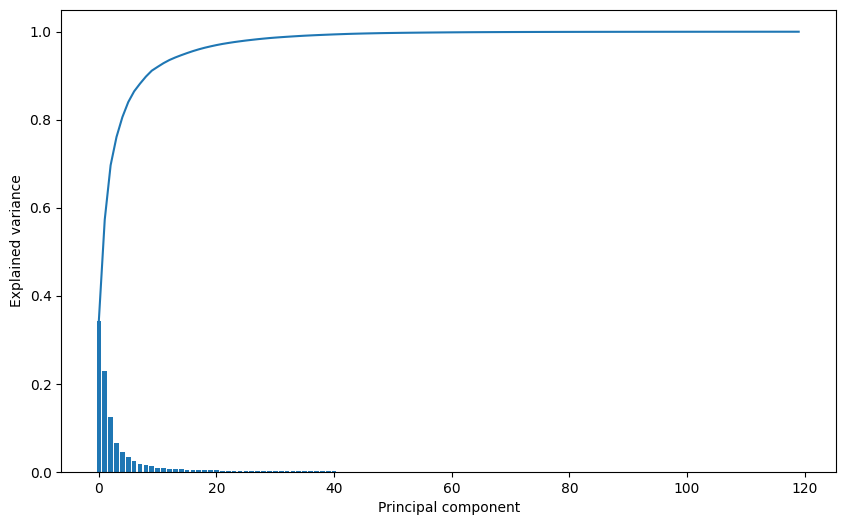

In [256]:
X = weighted_results.drop(columns=['actual_load'])
y = np.vstack(weighted_results['actual_load'])

scaler_X = MinMaxScaler(feature_range=(0, 1))
scaler_y = MinMaxScaler(feature_range=(0, 1))

X_norm = scaler_X.fit_transform(X)
y_norm = scaler_y.fit_transform(y)

pca = PCA()
X_pca = pca.fit(X_norm)

num_components = len(pca.explained_variance_ratio_)
plt.figure(figsize=(10, 6))
plt.bar(np.arange(num_components), pca.explained_variance_ratio_)
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('Principal component')
plt.ylabel('Explained variance')
plt.show()

In [267]:
pca = PCA(n_components=0.95)
pca.fit(X_norm)
X_pca = pca.transform(X_norm)
print(X_pca.shape)

(1820, 16)


## XGBoost Model Training & Evaluation

In [389]:
# 80% train, 20% test
X_train, X_test, y_train, y_test = train_test_split(X_pca, y_norm, test_size=0.2, random_state=42) 

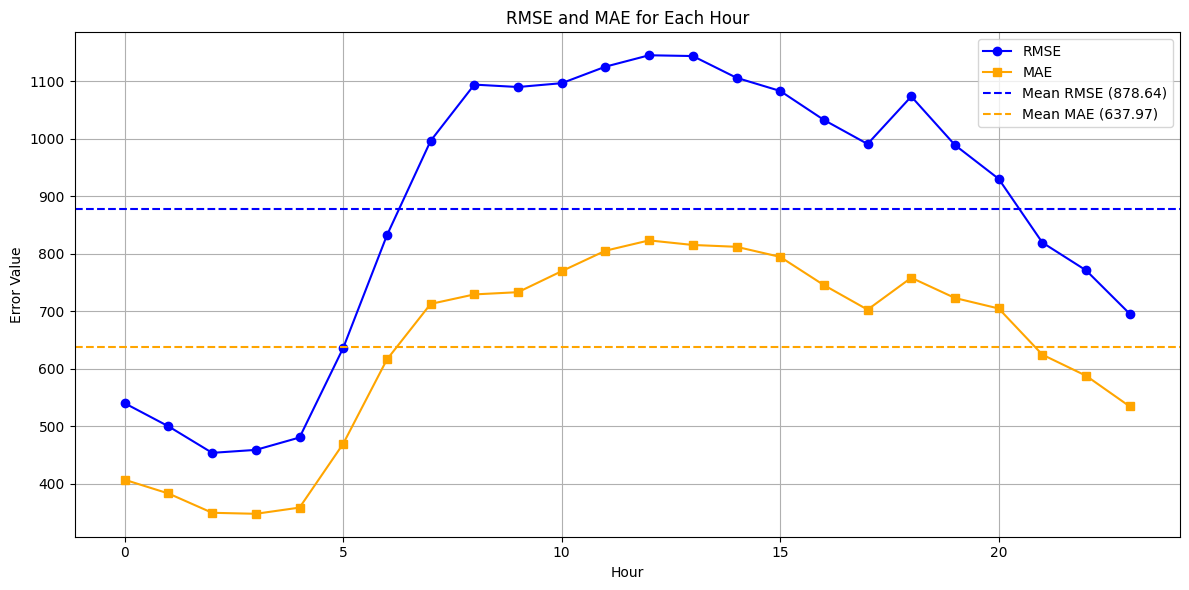

In [ ]:
params = {
        'eta': 0.025,                 # Learning rate; controls the step size during optimization.
        'max_depth': 5,               # Maximum depth of a tree; prevents overfitting and controls model complexity.
        'n_estimators': 600,          # Total number of boosting iterations (trees) to build.
        'subsample': 0.8,             # Fraction of training data used for each tree; reduces overfitting.
        'colsample_bytree': 0.8,      # Fraction of features used for each tree; reduces overfitting.
        'alpha': 0,                   # L1 regularization term on weights; controls model sparsity.
        'lambda': 0.15,               # L2 regularization term on weights; prevents overfitting.
        'gamma': 0,                   # Minimum loss reduction required for a split; controls tree pruning.
        'objective': 'reg:squarederror',  # Specifies the task to solve; here, regression using squared error loss.
        'eval_metric': 'rmse',        # Evaluation metric; calculates root mean squared error for validation.
        'min_child_weight': 10,       # Minimum sum of instance weights (hessian) in a child; controls overfitting.
        'booster': 'gbtree',          # Model type; uses tree-based boosting.
        'n_jobs': -1                  # Number of parallel threads; -1 uses all available CPU cores.
}

# Initialize XGBoost model with parameters
base_model = XGBRegressor(**params)
multioutput_model = MultiOutputRegressor(base_model)

# Fit the model
multioutput_model.fit(X_train, y_train)

# Predict
y_pred = multioutput_model.predict(X_test)
y_pred = scaler_y.inverse_transform(y_pred)
y_test_inv = scaler_y.inverse_transform(y_test)

# Evaluate the model
rmse = np.sqrt(mean_squared_error(y_test_inv, y_pred, multioutput='raw_values'))
mae = mean_absolute_error(y_test_inv, y_pred, multioutput='raw_values')
mean_rmse = np.mean(rmse)
mean_mae = np.mean(mae)


plt.figure(figsize=(12, 6))
plt.plot(rmse, label='RMSE', marker='o', linestyle='-', color='blue')
plt.plot(mae, label='MAE', marker='s', linestyle='-', color='orange')
plt.axhline(mean_rmse, color='blue', linestyle='--', label=f'Mean RMSE ({mean_rmse:.2f})')
plt.axhline(mean_mae, color='orange', linestyle='--', label=f'Mean MAE ({mean_mae:.2f})')

plt.title('RMSE and MAE for Each Hour')
plt.xlabel('Hour')
plt.ylabel('Error Value')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

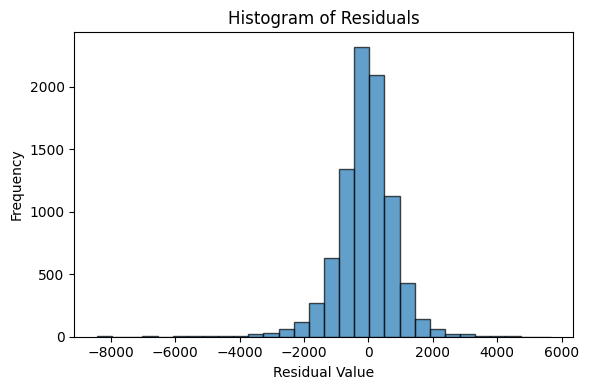

In [393]:
y_errors = y_pred-y_test_inv
y_errors_flattened = y_errors.flatten()

plt.figure(figsize=(6, 4))
plt.hist(y_errors_flattened, bins=30, edgecolor="k", alpha=0.7)
plt.title("Histogram of Residuals")
plt.xlabel("Residual Value")
plt.ylabel("Frequency")

plt.tight_layout()
plt.show()

## Summary

- Much better than benchmark
- Hasn't captured dependencies between hours as one model per hour trained, can be improved using a neural network technique